## Miscelaneous tasks with Perqueue and ASE DB

### Add individual entries to the DB

First, add the entries from another DB

In [19]:
from ase.db import connect
from pathlib import Path
import shutil
from herculestools.dft import RunConfiguration as RC

# Read and generate an atoms entry from the NEB run. Write/Update it to the DB.
struct_dir = RC.structures_dir
config_home = RC.home
home = Path.cwd()
copy_db_path = struct_dir/'hexag_perovs_strained_copy.db'
old_db_path = struct_dir/'hexag_perovs_strained.db'
#old_db_path = 'structures/hexag_perovs_wdiscards.db'

db_path = shutil.copy(old_db_path, copy_db_path)
#copy_db_path =  'structures/hexag_perovs_strained_copy.db'

#files_folder = Path('NEB/Ba7Nb4MoO20_p1_e0/').resolve().as_posix()
#name = 'Ba7Nb4MoO20_p1_neb'

with connect(old_db_path) as old_db:
    rows = old_db.select(mask='uniaxial')
    for sys_row in rows:
        row_id = sys_row.id
        sys_atoms = sys_row.toatoms()
        sys_kvps = sys_row.key_value_pairs
        sys_kvps['mask'] = 'x-axis'
        sys_kvps['name'] = sys_kvps['name'].replace('uniaxial', sys_kvps['mask'])
        
        row_dir = Path(sys_row.dir).resolve()
        # Check if the directory exists in the scratch
        if Path(scratch_dir := row_dir.as_posix().replace('energy','scratch3')).is_dir():
            #print(f"The directory {scratch_dir} exists")
            old_direc = scratch_dir
        elif Path(home_dir := row_dir.as_posix().replace('scratch3','energy')).is_dir():
            # Try to fetch the directory in the home
            #print(f"The directory {home_dir} exists")
            old_direc = home_dir
        else:
            print(f"No directory found for {row_dir}")
        
        rename_dir = old_direc.replace('uniaxial', sys_kvps['mask'])
        print(f"Renaming {old_direc} to {rename_dir}")
        # Rename the old directories to the new ones
        shutil.move(old_direc, rename_dir)
        # try:
        #     shutil.move(old_direc, new_dir)
        # except FileNotFoundError:
        #     # Check if the directory was already renamed
        #     if Path(new_dir).exists():
        #         print(f"Directory {new_dir} already exists")
        #     else:
        #         print(f"Directory {old_direc} not found")
        #         continue
        try:
            new_dir = Path(rename_dir).relative_to(home).as_posix()
        except ValueError:
            new_dir = Path(rename_dir).relative_to(config_home).as_posix()

        sys_kvps['dir'] = new_dir
        
        with connect(copy_db_path) as new_db:
           new_db.update(id=row_id, name=sys_kvps['name'], mask=sys_kvps['mask'], dir=sys_kvps['dir'])    
        #break

Renaming /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/uniaxial/e0 to /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/x-axis/e0
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_uniaxial_e0/init to /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_x-axis_e0/init
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_uniaxial_e0/final to /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_x-axis_e0/final
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/uniaxial/s1 to /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/x-axis/s1
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/uniaxial/s3 to /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/x-axis/s3
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_uniaxial_s1/init to /home/scratch

Then, modify the entry to match as best as possible with respect to the currrent scheme.

In [2]:

with connect(new_db_path) as db:
    sys_row = db.get(name=name)
    sys_id = sys_row.id
    sys_atoms = sys_row.toatoms()
    kvps = [kvp for kvp in sys_row]

    keys_values = {}
    keys_values['name'] = "Ba7Nb4MoO20_p1_e0_neb"
    keys_values['dir'] = files_folder
    keys_values['dopant']=int(sys_row.name[-5])
    keys_values['in_plane'] = 1.00
    db.update(sys_id, **keys_values)



Change the values of several entries at a time.

#### NEBs

In [25]:
from ase.db import connect
from pathlib import Path
import shutil

# Read and generate an atoms entry from the NEB run. Write/Update it to the DB.

db_path = 'structures/hexag_perovs_strained.db'
#copy_path = 'structures/hexag_perovs_strained_copy.db'

#copy_path = shutil.copy(db_path, copy_path)

#with connect(copy_path) as db:
with connect(db_path) as db:
    get_rows = db.select('barrier')
    kvps = {}
    for row in get_rows:
        row_id = row.id
        kvps['delta_e'] = abs(row.delta_e)
        name_parts = row.name.split('_')
        dist_name = name_parts[-2]
        print(dist_name)
        kvps['dopant'] = int(name_parts[1][-1])
        if dist_name=='s1':
            kvps['in_plane'] = 1.015
        elif dist_name=='s3':
            kvps['in_plane']=1.030
        elif dist_name=='c1':
            kvps['in_plane']=0.985
        elif dist_name=='c3':
            kvps['in_plane']=0.970
        elif dist_name=='e0':
            kvps['in_plane']=1.000
        
        db.update(row_id, **kvps)
        print(row_id,kvps)
        #break


s1
28 {'delta_e': 0.6102335000000494, 'dopant': 1, 'in_plane': 1.015}
s3
31 {'delta_e': 0.6151655599999231, 'dopant': 1, 'in_plane': 1.03}
s1
32 {'delta_e': 0.6243580099999235, 'dopant': 1, 'in_plane': 1.015}
e0
33 {'delta_e': 0.5970954699998856, 'dopant': 1, 'in_plane': 1.0}


#### Others

In [2]:
from ase.db import connect
from pathlib import Path
import shutil

# Read and generate an atoms entry from the NEB run. Write/Update it to the DB.

db_path = 'structures/hexag_perovs_strained.db'
#copy_path = 'structures/hexag_perovs_strained_copy.db'

#copy_path = shutil.copy(db_path, copy_path)

#with connect(copy_path) as db:
with connect(db_path) as db:
    get_rows = db.select(selection='in_plane=1.010')
    kvps = {}
    for row in get_rows:
        row_id = row.id
        row_in_plane = row.in_plane
        if row_in_plane==1.010:
            in_plane = 1.015
        elif row_in_plane==0.990:
            in_plane = 0.985

        print(row.id, row_in_plane)
        #db.update(row_id, in_plane=in_plane)
        #break
        

In [36]:
print([row for row in get_rows])

[]


### Change the resources of the queued jobs to the epyc96 partition.

In [1]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources

# Get the entries from the active pq database and modify their resources
with PersistentQueue() as pq:
    entries = pq.get_entries()
    
s = Selection(states='fw', names='preNEB_Ba7Nb4MoO20_p*')
targets = s.filter(entries)

# Modify the resources of the entries
new_res = Resources.from_string("112:1:xeon56:50h")
with PersistentQueue() as pq:
    for en in targets:
        en._task.resources = new_res
        pq.save_resources(en.key, new_res, False)
        print(en)
    
        
    # pq_key = en.key
    # #print(en)
    # with PersistentQueue() as pq:
    #     if pq.get_code(pq_key).name != 'neb.py':
    #         print(f"New resources: {new_res1} for pq key: {pq_key}")
    #         pq.save_resources(pq_key, Resources(new_res1), all=False)
    #         print(en)
        #else:
        #    print(f"New resources: {new_res2} for pq key: {pq_key}")
        #    pq.save_resources(pq_key, Resources(new_res2), all=True)
        
        #pq.resubmit(en)
    
    #break

Entry(task=Task(code=PosixPath('/home/energy/armoma/phd/hex_perovs/strained/codes/preneb.py'), args={}, resources=Resources(cores=112, processes=1, tmax=180000, nodename='xeon56')), entry_key=30, name='preNEB_Ba7Nb4MoO20_p1', mq_id=7943062, state='f', err_txt="CalculationFailed('vasp in /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_x_axis_c5/init returned an error: 1')", entry_group_key=1, pq_args={'pq_index': [1]}, data=None)


### Modify the arguments of the entry

In [17]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources

db_path = 'structures/hexag_perovs_strained.db'
db = connect(db_path)

# Get the entries from the active pq database and modify their resources
with PersistentQueue() as pq:
    entries = pq.get_entries()

rattle_dict = {'y_axis': 1.015, 'biaxial': 0.985}

s = Selection(names='CINEB_*', states='s')
targets = s.filter(entries)
args_to_add = {'rattle': True}
for en in targets:
    neb_id = en.data['neb_id']
    neb_row = db.get(neb_id)
    in_plane = neb_row.in_plane
    mask = neb_row.mask
    # Match each key and value pair from the rattle dictionary
    for key, value in rattle_dict.items():
        if in_plane==value and mask==key:
            with PersistentQueue() as pq:
                old_args = pq.get_args(en.key)
                new_args = {**old_args, **args_to_add}
                pq.save_args(en.key, new_args, all=False)
            
            with PersistentQueue() as pq:
                print(en)
                pq.resubmit(en)
        
        else:
            continue
    
# # Modify the resources of the entries
# new_args = {'vasp': {'symprec': 1e-09, 'isym': 0, 'algo': 'VeryFast'}}
# with PersistentQueue() as pq:
#     for en in targets:
#         pq.save_args(en.key, new_args, all=False)

# with PersistentQueue() as pq:
#     for en in targets:
#         print(en)
#         pq.resubmit(en)
        

Entry(task=Task(code=PosixPath('/home/energy/armoma/phd/hex_perovs/strained/codes/neb.py'), args={'climb': True}, resources=Resources(cores=192, processes=1, tmax=180000, nodename='epyc96')), entry_key=50, name='CINEB_Ba7Nb4MoO20_p1', mq_id=8047148, state='s', err_txt=None, entry_group_key=1, pq_args={'pq_index': [11]}, data={'trajectory': 'Ba7Nb4MoO20_p1_y_axis_s1_4.traj', 'neb_id': 111})
8047148 ./ neb.py 50 180000 +2 192:1:epyc96:50h 22:18:04:13 done 2:27:00
1 task removed
8138708 ./ neb.py 50 180000 +2 192:1:epyc96:50h
1 task submitted
Entry(task=Task(code=PosixPath('/home/energy/armoma/phd/hex_perovs/strained/codes/neb.py'), args={'climb': True}, resources=Resources(cores=192, processes=1, tmax=180000, nodename='epyc96')), entry_key=55, name='CINEB_Ba7Nb4MoO20_p1', mq_id=8088779, state='s', err_txt=None, entry_group_key=1, pq_args={'pq_index': [6]}, data={'trajectory': 'Ba7Nb4MoO20_p1_biaxial_c1_7.traj', 'neb_id': 116})
8138710 ./ neb.py 55 180000 +2 192:1:epyc96:50h
1 task submit

### Modify the state of an entry

In [1]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources
from perqueue.task_classes.util_classes import EntryState
import perqueue.coordinator as coord

# Get the entries from the active pq database and modify their resources
with PersistentQueue() as pq:
    entries = pq.get_entries()
    
s = Selection(ids=55)
targets = s.filter(entries)

#new_state = EntryState('q')
with PersistentQueue() as pq:
    for en in targets:
        # Change the state of the entry
        coord.set_state(pq._backend, en.key, EntryState.succeeded, None)
        
        # Populate the data field in the entry
        #coord.set_data(pq._backend, en.key, {'db_id': 1})
        
        # Resubmit the entry
        #pq.resubmit(en)
        
        #break
        

#### Change the args of an entry.

In [4]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources
from perqueue.task_classes.util_classes import EntryState
import perqueue.coordinator as coord

# Get the succesful NEB jobs with PQ
with PersistentQueue() as pq:
    entries = pq.get_entries()

s = Selection(states='qr', names='strain*')
targets = s.filter(entries=entries)

resources = Resources.from_string('56:1:xeon56:50h')
#args = {'climb': True}
#data = {'trajectory': 'Ba7Nb4MoO20_p1_biaxial_e0_1.traj', 'neb_id': 43}

with PersistentQueue() as pq:
    for en in targets:
        # Store the data in the entry
        #coord.set_data(pq._backend, en.key, data)
        #pq.save_resources(en.key, resources, False)
        #key = en.key
        #pq.save_args(key, args, False)
        pq.resubmit(en)

7930385 ./ apply_strain.py 2 180000 +2 96:1:epyc96:50h 1:16 queued 0:00
1 task removed
7930418 ./ apply_strain.py 2 180000 +2 56:1:xeon56:50h
1 task submitted
7930386 ./ apply_strain.py 3 180000 +2 56:1:xeon56:50h 1:16 queued 0:00
1 task removed
7930419 ./ apply_strain.py 3 180000 +2 56:1:xeon56:50h
1 task submitted
7930387 ./ apply_strain.py 4 180000 +2 40:1:xeon40el8_768:50h 1:16 queued 0:00
1 task removed
7930420 ./ apply_strain.py 4 180000 +2 56:1:xeon56:50h
1 task submitted
7930388 ./ apply_strain.py 5 180000 +2 96:1:epyc96:50h 1:16 queued 0:00
1 task removed
7930421 ./ apply_strain.py 5 180000 +2 56:1:xeon56:50h
1 task submitted
7930389 ./ apply_strain.py 6 180000 +2 56:1:xeon56:50h 1:16 queued 0:00
1 task removed
7930422 ./ apply_strain.py 6 180000 +2 56:1:xeon56:50h
1 task submitted
7930390 ./ apply_strain.py 7 180000 +2 40:1:xeon40el8_768:50h 1:16 queued 0:00
1 task removed
7930423 ./ apply_strain.py 7 180000 +2 56:1:xeon56:50h
1 task submitted
7930391 ./ apply_strain.py 8 180

In [11]:
resources = Resources.from_string('48:1:xeon24el8_test:10m')
with PersistentQueue() as pq:
    entry= pq.get_entry(key=12)
    pq.save_resources(entry.key, resources, False)

In [ ]:
data = {'trajectory': 'Ba7Nb4MoO20_p1_biaxial_e0_1.traj', 'neb_id': 43}

## Modify the entries of the DB

### Miscelaneous

In [8]:
from ase.db import connect
import shutil
from ase.io import read
from ase.dft.bandgap import bandgap
from herculestools.dft import load_run, RunConfiguration as RC

rc_home = RC.home

# Connect to the database
db_path = 'structures/hexag_perovs_strained.db'
db_copy = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy)

# Connect to the copied database
ids = []
with connect(db_copy) as db:
    rows = db.select()
    for row in rows:
        if not hasattr(row, 'energy'):
            continue
        # Check for entries that have the 'x-axis' mask
        if row.mask == 'x-axis':
            #print(row.id, row.name, row.mask, row.dir)
            mask = 'x_axis'
            name = row.name.replace('x-axis', mask)
            old_dir = row.dir
            new_dir = row.dir.replace('x-axis', mask)
            #print(name, direc)
            
            db.update(row.id, mask=mask, name=name, dir=new_dir)
            # We can update the entries in the database. But we can also rename the directories the data is stored in
            #old_dir = rc_home/old_dir
            #new_dir = rc_home/new_dir
            # Move the contents of the old directory to the new one
            #shutil.move(old_dir, new_dir)
    

In [18]:
from ase.db import connect
import shutil
from ase.io import read
from ase.dft.bandgap import bandgap
from herculestools.dft import load_run, RunConfiguration as RC

rc_home = RC.home

# Connect to the database
#db_path = 'structures/hexag_perovs_strained.db'
db_copy = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
#shutil.copy(db_path, db_copy)

# Connect to the copied database
ids = []
with connect(db_copy) as db:
    rows = db.select()
    for row in rows:
        if not hasattr(row, 'energy'):
            continue
        # We now change the entries that have incorrectly assigned mask names
        mask = row.mask
        if mask not in row.name:
            #print(row.id, row.name, row.mask, row.dir)
            #Change the mask in the name
            if mask == 'x_axis':
                name = row.name.replace('x', mask)
                old_dir = row.dir
                new_dir = row.dir.replace('x', mask)
                db.update(row.id, name=name, dir=new_dir)
            if mask == 'y_axis':
                name = row.name.replace('y', mask)
                old_dir = row.dir
                new_dir = row.dir.replace('y', mask)
                db.update(row.id, name=name, dir=new_dir)
                old_dir = rc_home/old_dir
                new_dir = rc_home/new_dir
                #Move the contents of the old directory to the new one
                try:
                    shutil.move(old_dir, new_dir)
                except FileNotFoundError:
                    print(f"Directory {old_dir} not found")
                    continue
            print(name, new_dir)
        

Directory /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_s1/init not found
Directory /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_s1/final not found
Ba7Nb4MoO20_p1_x_axis_c1_vi preNEB/Ba7Nb4MoO20_p1_x_axis_c1/init
Ba7Nb4MoO20_p1_x_axis_c1_vf preNEB/Ba7Nb4MoO20_p1_x_axis_c1/final
Ba7Nb4MoO20_p1_x_axis_s1_vi preNEB/Ba7Nb4MoO20_p1_x_axis_s1/init
Ba7Nb4MoO20_p1_x_axis_s1_vf preNEB/Ba7Nb4MoO20_p1_x_axis_s1/final
Ba7Nb4MoO20_p1_x_axis_s3_vi preNEB/Ba7Nb4MoO20_p1_x_axis_s3/init
Ba7Nb4MoO20_p1_x_axis_s3_vf preNEB/Ba7Nb4MoO20_p1_x_axis_s3/final
Ba7Nb4MoO20_p1_y_axis_c1_vi /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_axis_c1/init
Ba7Nb4MoO20_p1_y_axis_c1_vf /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_axis_c1/final


In [26]:
from ase.db import connect
import shutil
from herculestools.dft import RunConfiguration as RC

rc_home = RC.home

# Connect to the database
#db_path = 'structures/hexag_perovs_strained.db'
db_copy = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
#shutil.copy(db_path, db_copy)

# Connect to the copied database
ids = []
with connect(db_copy) as db:
    rows = db.select(selection='mask=x_axis', sort='-name')
    # Some entries have been duplicated. We need to remove the duplicates by filtering out their names.
    names_list = []
    for row in rows:
        # Get the id and name of the row
        row_id = row.id
        row_name = row.name
        # Feed the id and name to the list of duplicates
        names_list.append((row_id, row_name))
        
    # Check for duplicate names in the list
    ids_to_delete = []
    for i in range(len(names_list)-1):
        if names_list[i][1] == names_list[i+1][1]:
            # Get the id of the duplicate entry
            row_id = names_list[i+1][0]
            ids_to_delete.append(row_id)
            print(f"Deleting duplicate name: {names_list[i+1][1]}, id: {names_list[i+1][0]}")
            #break
    db.delete(ids_to_delete)

Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s3_vi, id: 69
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s3_vf, id: 70
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s3, id: 10
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s1_vi, id: 67
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s1_vf, id: 68
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s1, id: 9
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c3, id: 22
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c1_vi, id: 63
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c1_vf, id: 64
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c1, id: 19


In [22]:
print(len(names_list))

35


### Adding the energies of formation

In [91]:
from ase.db.sqlite import SQLite3Database
from collections import Counter
import ase.data as data
from herculestools.dft import RunConfiguration as RC
import shutil
from ase.db import connect
from pathlib import Path

here = Path.cwd()
rc_home = RC.home
rc_structs = RC.structures_dir
structures_dir = here / 'structures'
db_path = rc_structs / 'hexag_perovs_strained.db'
copy_db_path = structures_dir / 'hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, copy_db_path)

# Connect to the copied database
db = connect(copy_db_path)

# First, we define the function that will calculate the energy of the oxygen molecule.
def oxy_energy():
    # The energies of the hydrogen and the water molecules
    mol_db: SQLite3Database = connect('structures/molecules.db')
    h2_energy = mol_db.get(name='H2').energy
    h2o_energy = mol_db.get(name='H2O').energy
       
    # The deltaE of water formation is an empirical value
    DE_H2O = -2.4905 # From the free energies obtained by Benjamin with R2SCAN.
    
    # The energy of the oxygen molecule
    o_energy = (h2o_energy - h2_energy) - DE_H2O

    return o_energy


# Then, we define the function that will calculate the heat of formation.
def heat_of_form(id: int, db: SQLite3Database):
    ref_db: SQLite3Database = connect('structures/references.db')
    
    # The energy of the oxygen molecule
    o_energy = oxy_energy()

    # Take the input structure and get its atomic composition
    atoms = db.get(id).toatoms()
    numbers = [(data.chemical_symbols[atom], count) for atom, count in Counter(atoms.numbers).items()]
    toten = atoms.get_potential_energy()
    natoms = atoms.get_global_number_of_atoms()
    
    # Read from the references database the energies of the elements
    ref_atoms = {}
    for element, _ in numbers:
        ref_row = ref_db.get(name=element)
        ref_energy = ref_row.energy
        ref_natoms = ref_row.natoms
        if element == 'O':
            ref_energy = o_energy
            ref_natoms = 1
        ref_energy_per_atom = ref_energy / ref_natoms
        ref_atoms[element] = ref_energy_per_atom

    # Calculate the heat of formation
    hof = (toten - sum([count * ref_atoms[element] for element, count in numbers]))/natoms#* 96.485 #kJ/mol
    
    return hof

# relaxed_rows = [row.name[:-6] for row in db.select('o_vac_energy')]
relaxed_rows = [row.id for row in db.select('jobtype=relaxation')]
distorted_rows = [row.id for row in db.select('jobtype=strain')]
jobs = relaxed_rows + distorted_rows
for id in jobs:
    hof = heat_of_form(id, db)
    print(f"Updating {id} with hof {hof:.2f}")
    with db:
        db.update(id, hof=hof)
                 
       

Updating 1 with hof -2.83
Updating 54 with hof -2.81
Updating 55 with hof -2.82
Updating 3 with hof -2.83
Updating 4 with hof -2.83
Updating 15 with hof -2.83
Updating 18 with hof -2.82
Updating 23 with hof -2.83
Updating 39 with hof -2.82
Updating 42 with hof -2.82
Updating 44 with hof -2.82
Updating 48 with hof -2.78
Updating 56 with hof -2.83
Updating 57 with hof -2.83
Updating 58 with hof -2.83
Updating 59 with hof -2.83
Updating 60 with hof -2.83
Updating 65 with hof -2.83
Updating 66 with hof -2.83
Updating 73 with hof -2.83
Updating 74 with hof -2.82
Updating 75 with hof -2.82
Updating 76 with hof -2.79
Updating 77 with hof -2.82
Updating 78 with hof -2.82
Updating 79 with hof -2.82
Updating 80 with hof -2.82
Updating 81 with hof -2.82
Updating 82 with hof -2.82
Updating 87 with hof -2.81
Updating 90 with hof -2.81
Updating 91 with hof -2.81
Updating 92 with hof -2.80
Updating 93 with hof -2.80
Updating 94 with hof -2.82
Updating 95 with hof -2.80
Updating 96 with hof -2.80
Upda

### Calculating the oxygen vacancy formation energies

In [92]:
from ase.io import read
import re
from ase.db.sqlite import SQLite3Database
from collections import Counter
import ase.data as data
from herculestools.dft import RunConfiguration as RC
import shutil
from ase.db import connect
from pathlib import Path
from time import sleep
import numpy as np

here = Path.cwd()
#rc_home = RC.home
#rc_structs = RC.structures_dir
structures_dir = here / 'structures'
#db_path = rc_structs / 'hexag_perovs_strained.db'
copy_db_path = structures_dir / 'hexag_perovs_strained_copy.db'

# Copy the database to a new location
#shutil.copy(db_path, copy_db_path)

# Connect to the copied database
db = connect(copy_db_path)


def oxy_energy():
    # The energies of the hydrogen and the water molecules
    mol_db: SQLite3Database = connect('structures/molecules.db')
    h2_energy = mol_db.get(name='H2').energy
    h2o_energy = mol_db.get(name='H2O').energy
       
    # The deltaE of water formation is an empirical value
    DE_H2O = -2.4905 # From the free energies obtained by Benjamin with R2SCAN.
    
    # The energy of the oxygen molecule
    o_energy = (h2o_energy - h2_energy) - DE_H2O

    return o_energy

def get_oxy_vac_energy(entry: str, db: SQLite3Database):
    # Get the oxygen vacancy formation energy
    name_parts = entry.split('_')
    entry_name = name_parts[0]
    dopant_site = name_parts[1]
    mask = name_parts[2] if 'biaxial' in name_parts else '_'.join(name_parts[2:4])
    strain = name_parts[-2]
    sys_name = '_'.join([entry_name, dopant_site, mask, strain])

    # Generate a dictionary of in_plane values
    #in_plane_dict = {'s7': 1.070, 's5': 1.050, 's3': 1.030, 's1': 1.015, 'e0': 1.000, 'c1': 0.985, 'c3': 0.970, 'c5': 0.950, 'c7': 0.930}    
    #in_plane = in_plane_dict[mask]

    # The name of the relaxed structure
    if strain == 'e0':
        relax_row = db.get(name=f"{'_'.join([entry_name, dopant_site])}_r")
    else:
        relax_row = db.get(name=f"{sys_name}")
    energy_r = relax_row.energy
    natoms_r = relax_row.natoms
    
    #print(f"Energy of {sys_name} = {energy_r:.2f}")
    #print(f"Number of atoms in {sys_name} = {natoms_r}")
    vi_row = db.get(name=f"{sys_name}_vi")
    vf_row = db.get(name=f"{sys_name}_vf")
    energy_vi = vi_row.energy
    energy_vf = vf_row.energy
    delta_e = energy_vf - energy_vi

    # plug in the values of the oxygen molecule
    o_energy = oxy_energy()
    
    # The energy of the structure with the oxygen vacancies
    if natoms_r == 32:
        o_energy_vi = energy_vi - (4 * energy_r) + o_energy
        o_energy_vf = energy_vf - (4 * energy_r) + o_energy
    
    else:
        o_energy_vi = energy_vi - energy_r + o_energy
        o_energy_vf = energy_vf - energy_r + o_energy
    
    with db:
        db.update(vi_row.id, o_vac_energy=o_energy_vi, delta_e=delta_e)
        db.update(vf_row.id, o_vac_energy=o_energy_vf, delta_e=delta_e)

    return print(f"System: {sys_name}, o_energy_vi = {o_energy_vi:.2f}, o_energy_vf = {o_energy_vf:.2f}, delta_e = {delta_e:.2f}")
#    return o_energy_vi, o_energy_vf

rows = [row for row in db.select('jobtype=vacancies') if 'vi' in row.name]
for vi_row in rows:
    #print(vi_row.name)
    vi_name = vi_row.name
    vf_name = name[:-1] + 'f'
    get_oxy_vac_energy(vi_name, db)


System: Ba7Nb4MoO20_p1_biaxial_e0, o_energy_vi = 5.62, o_energy_vf = 5.02, delta_e = -0.60
System: Ba7Nb4MoO20_p1_x_axis_e0, o_energy_vi = 5.62, o_energy_vf = 5.02, delta_e = -0.60
System: Ba7Nb4MoO20_p1_x_axis_s1, o_energy_vi = 5.61, o_energy_vf = 5.00, delta_e = -0.61
System: Ba7Nb4MoO20_p1_x_axis_s3, o_energy_vi = 5.59, o_energy_vf = 4.97, delta_e = -0.62
System: Ba7Nb4MoO20_p1_biaxial_s1, o_energy_vi = 5.60, o_energy_vf = 4.98, delta_e = -0.62
System: Ba7Nb4MoO20_p1_biaxial_s3, o_energy_vi = 5.57, o_energy_vf = 4.93, delta_e = -0.65
System: Ba7Nb4MoO20_p1_x_axis_c1, o_energy_vi = 5.64, o_energy_vf = 5.05, delta_e = -0.59
System: Ba7Nb4MoO20_p1_x_axis_c3, o_energy_vi = 5.65, o_energy_vf = 5.07, delta_e = -0.58
System: Ba7Nb4MoO20_p1_biaxial_c1, o_energy_vi = 5.65, o_energy_vf = 5.08, delta_e = -0.57
System: Ba7Nb4MoO20_p1_biaxial_c3, o_energy_vi = 5.69, o_energy_vf = 5.15, delta_e = -0.54
System: Ba7Nb4MoO20_p1_x_axis_c5, o_energy_vi = 5.68, o_energy_vf = 5.10, delta_e = -0.58
Syste

## Generate a CSV file with the entries in the DB

In the following lines I will take from the current entries in the database and generate a data file I can use for consequent treatment of the data.

### Treat the DB for proper results

Check if the entries of the strained P3 are stored properly, else, reformat the entries in the DB.

In [2]:
from ase.db import connect
import shutil


"""
The NEB entries in the database need a slight adjustment to their columns 

1. The first thing that needs to change is the 'mask' column, I have to assign this value to all entries.append

2. Determine whether the entry is or not a climbing-image calculation. Assign a boolean value to the 'climb' column

3. The 'in_plane' column is a float value that needs to be assigned to all entries. 

Most of these values can be extracted from the name of the entry.

Try first with a copy DB.
"""

# Connect to the database

db_path = 'structures/hexag_perovs_strained.db'
db_copy_path = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy_path)

# Generate a dictionary of in_plane values
in_plane_dict = {'s7': 1.070, 's5': 1.050, 's3': 1.030, 's1': 1.015, 'e0': 1.000, 'c1': 0.985, 'c3': 0.970, 'c5': 0.950, 'c7': 0.930}

masks_dict = {'x':'x_axis', 'y':'y_axis'}

# Connect to the copied database
with connect(db_copy_path) as db:
    # Get all the neb entries in the database
    rows = db.select(selection='barrier')
    for row in rows:
        row_id = row.id
        row_name = row.name
        # Split the name of the entry
        name_components = row_name.split('_')
        # Get the dopant
        dopant = int(name_components[1][-1])
        # Is the entry a climbing image calculation?
        if "CI" in row_name:
            climb = True
            # Get the in_plane value from the name components
            in_plane = in_plane_dict[name_components[-3]]
        else:
            climb = False
            in_plane = in_plane_dict[name_components[-2]]
        # Get the mask value from the name components, for the x and y axis the match will only be for the 'x' and 'y' characters
        mask = name_components[2]
        if mask in masks_dict.keys():
            mask = masks_dict[mask]
                

        print(row_name, mask, climb, in_plane)
        db.update(row_id, dopant=dopant, mask=mask, climb=climb, in_plane=in_plane)
        
        


Ba7Nb4MoO20_p1_x_axis_s1_neb x_axis False 1.015
Ba7Nb4MoO20_p1_x_axis_s3_neb x_axis False 1.03
Ba7Nb4MoO20_p1_biaxial_s1_neb biaxial False 1.015
Ba7Nb4MoO20_p1_biaxial_c1_neb biaxial False 0.985
Ba7Nb4MoO20_p1_biaxial_s3_neb biaxial False 1.03
Ba7Nb4MoO20_p1_x_axis_c3_neb x_axis False 0.97
Ba7Nb4MoO20_p1_x_axis_c1_neb x_axis False 0.985
Ba7Nb4MoO20_p1_biaxial_e0_neb biaxial False 1.0
Ba7Nb4MoO20_p1_biaxial_c3_neb biaxial False 0.97
Ba7Nb4MoO20_p1_x_axis_s3_CI_neb x_axis True 1.03
Ba7Nb4MoO20_p1_x_axis_c5_neb x_axis False 0.95
Ba7Nb4MoO20_p1_biaxial_c5_neb biaxial False 0.95
Ba7Nb4MoO20_p1_y_axis_s3_neb y_axis False 1.03
Ba7Nb4MoO20_p1_y_axis_s1_neb y_axis False 1.015
Ba7Nb4MoO20_p1_y_axis_c5_neb y_axis False 0.95
Ba7Nb4MoO20_p1_y_axis_c3_neb y_axis False 0.97
Ba7Nb4MoO20_p1_y_axis_c1_neb y_axis False 0.985
Ba7Nb4MoO20_p1_x_axis_c1_CI_neb x_axis True 0.985
Ba7Nb4MoO20_p1_x_axis_s1_CI_neb x_axis True 1.015
Ba7Nb4MoO20_p1_biaxial_s1_CI_neb biaxial True 1.015
Ba7Nb4MoO20_p1_biaxial_s3_CI_n

#### Modify the e0 entries so that they're not part of the starting masks

In [6]:
from ase.db import connect
import shutil
from pathlib import Path
from ase.io import read

db_path = 'structures/hexag_perovs_strained.db'
db_copy_path = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy_path)

# Connect to the copied database
with connect(db_copy_path) as db:
    #rows = db.select(selection='in_plane=1.0')
    #rows = db.select(selection='jobtype=relaxation')
    rows = db.select(selection='barrier,in_plane=1.0')
    for row in rows:
        row_id = row.id
        # in_plane = 1.000
        mask = 'equil'
        # direc = Path(row.dir)
        # vasprun = direc/ 'vasprun.xml'
        # if vasprun.exists():
        # atoms = read(vasprun, index=-1)
        # energy = atoms.get_potential_energy()
        # else:
        #    break
        db.update(row_id, mask=mask)
        #print(row_id)

#### Make it easier to filter jobs by adding their jobtype

In [3]:
from ase.db import connect
import shutil

#db_path = 'structures/hexag_perovs_strained.db'
db_copy_path = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
#shutil.copy(db_path, db_copy_path)

jobtypes_dict = {'_neb': 'migration', '_vi':'vacancies', '_vf':'vacancies', '_r':'relaxation'}

# Connect to the copied database
with connect(db_copy_path) as db:
    rows = db.select()
    for row in rows:
        row_id = row.id
        row_name = row.name
        jobtype = 'strain'
        for key in jobtypes_dict.keys():
            if key in row_name:
                jobtype = jobtypes_dict[key]
                break
        db.update(row_id, jobtype=jobtype)
        

### Generating the CSVs

We will generate two CSV files. One will contain the information from the relaxations. And the second one, the information from the NEBs. 

#### Here, the strained calculations

In [55]:
from ase.db import connect
from pathlib import Path
import pandas as  pd
import numpy as np
import re

# Connect to the database
#db_path = 'structures/hexag_perovs_strained.db'
db_path = 'structures/hexag_perovs_strained_copy.db'

# Read the database
with connect(db_path) as db:
    strain_rows = db.select('jobtype=strain')
    relax_rows = db.select('jobtype=relaxation')

    # Merge the two generators
    rows = [*strain_rows, *relax_rows]

    # Create a dictionary to store the data
    data_dict = {'name':[], 'natoms':[], 'dopant':[], 'mask':[], 'c_lat': [], 'in_plane':[], 'hof': [], 'energy':[]}

    # Extract the lattice information from the name of the entry
    for row in rows:
        atoms = row.toatoms()
        lattice = atoms.cell.cellpar()
        #a_lat = lattice[0]
        #b_lat = lattice[1]
        c_lat = lattice[2]

        data_dict['name'].append(row.name)
        data_dict['dopant'].append(row.dopant)
        data_dict['natoms'].append(row.natoms)
        data_dict['mask'].append(row.mask)
        data_dict['c_lat'].append(c_lat)
        data_dict['in_plane'].append(row.in_plane)
        data_dict['hof'].append(row.hof)
        data_dict['energy'].append(row.energy)

    # Create a pandas dataframe from the dictionary
    df = pd.DataFrame(data_dict)
    #print(df)
    df.to_csv('strained_perovskite_energies.csv', index=False)


#### Here, for the endpoints

In [44]:
from ase.db import connect
from pathlib import Path
import pandas as  pd
import numpy as np
import re

# Connect to the database
db_path = 'structures/hexag_perovs_strained.db'

# Read the database
with connect(db_path) as db:
    rows = db.select('jobtype=vacancies')

    # Create a dictionary to store the data
    data_dict = {'name':[], 'mask':[], 'in_plane':[], 'oxy_vac_energy':[], 'delta_e':[]}
    for row in rows:
        data_dict['name'].append(row.name)
        data_dict['mask'].append(row.mask)
        data_dict['in_plane'].append(row.in_plane)
        data_dict['oxy_vac_energy'].append(row.o_vac_energy)
        data_dict['delta_e'].append(row.delta_e)
    
    # Create a pandas dataframe from the dictionary
    df = pd.DataFrame(data_dict)
    #print(df)
    df.to_csv('strained_perovskite_vacancies.csv', index=False)

#### Now the migration barriers

In [7]:
from ase.db import connect
from pathlib import Path
import pandas as  pd
import numpy as np
import re

# Connect to the database
db_path = 'structures/hexag_perovs_strained.db'

# Read the database
with connect(db_path) as db:
    # Create a dictionary to store the data
    data_dict = {'name':[], 'natoms': [], 'dopant':[], 'mask':[], 'in_plane':[], 'delta_e':[], 'barrier':[], 'climb':[], 'forward_e':[], 'reverse_e':[], 'kra':[]}
    
    vac_rows = db.select('jobtype=vacancies')
    mig_rows = db.select('jobtype=migration')
    
    for row in mig_rows:
        data_dict['name'].append(row.name)
        data_dict['dopant'].append(row.dopant)
        data_dict['natoms'].append(row.natoms)
        data_dict['mask'].append(row.mask)
        data_dict['in_plane'].append(row.in_plane)
        data_dict['barrier'].append(row.barrier)
        data_dict['climb'].append(row.climb)
        data_dict['forward_e'].append(row.forward_e)
        data_dict['reverse_e'].append(row.reverse_e)
        data_dict['delta_e'].append(row.delta_e)
        data_dict['kra'].append(row.kra_energy)
    
    # Create a pandas dataframe from the dictionary
    df = pd.DataFrame(data_dict)
    #print(df)
    df.to_csv('strained_perovskite_barriers.csv', index=False)


## Generating the plots for the strained perovskites

Here we do a quick plot of the energies against strain for the distorted structures. And then, a barrier against strain for the NEB calculations.

### Plot of the strain-energy relations.

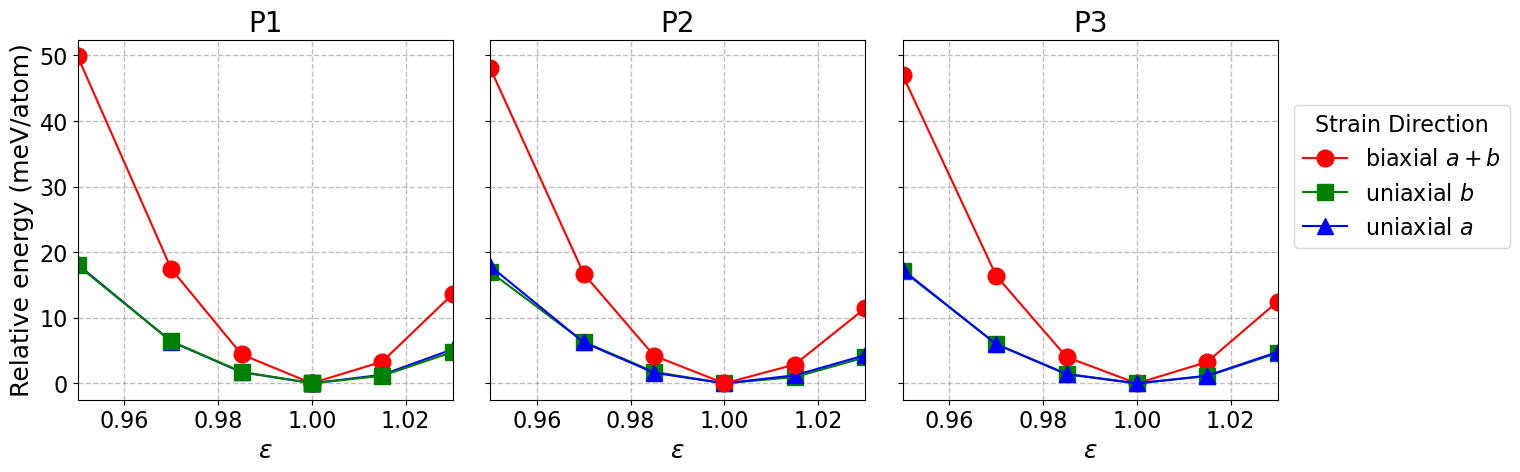

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_energies.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy

# Sort the data by the masks: biaxial, x-axis, y-axis
data = data.sort_values(by='mask')
# Get the unique dopants
dopants = data['dopant'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for dopant in dopants:
    # get the equilibrium data for the dopant
    equil_data = data[(data['dopant']==dopant) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])
# Sort the data by the in-plane strain
data = data.sort_values(by='in_plane')

# Set a color map for the masks
colors = ['r', 'g', 'b']
mask_colors = {mask:color for mask, color in zip(data['mask'].unique(), colors)}

markers = ['o', 's', '^'] 
mask_markers = {mask:marker for mask, marker in zip(data['mask'].unique(), markers)}

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Create a figure
fig, ax = plt.subplots(1, len(dopants), figsize=(20, 4), sharey=True, gridspec_kw={'top': 0.95, 'bottom': 0.05, 'left': 0.15, 'right': 0.75, 'wspace': 0.1})

xlims = [0.95, 1.03]

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $a+b$'}
handles = []
labels = []
for dopant in dopants:
    # Get the data for the dopant
    dopant_data = data[data['dopant']==dopant]
    # Get the unique mask values
    masks = dopant_data['mask'].unique()

    # Get the equilibrium energy
    for mask in masks:
        mask_data = dopant_data[dopant_data['mask']==mask]
        min_energy = mask_data['energy'].min()
        ax[dopant-1].plot(mask_data['in_plane'], 1000*(mask_data['energy'] - min_energy)/mask_data['natoms'], 
                          label=names_dict[mask], color=mask_colors[mask], marker=mask_markers[mask], markersize=12)
    ax[dopant-1].grid(True, linestyle='--', alpha=0.5, linewidth=1, color='gray')
    ax[dopant-1].set_xlim(xlims)
    ax[dopant-1].set_title(f'P{dopant}', fontsize=20)
    ax[dopant-1].set_xlabel(r'$\varepsilon$', fontsize=18)
    handles, labels = ax[dopant-1].get_legend_handles_labels()
    ax[dopant-1].yaxis.set_tick_params(labelsize=16)
    ax[dopant-1].xaxis.set_tick_params(labelsize=16)

ax[0].set_ylabel('Relative energy (meV/atom)', fontsize=18)
plt.legend(handles, labels, loc='upper right', title='Strain Direction', bbox_to_anchor=(1.65, 0.85), ncol=1, fontsize=16, title_fontsize=16)
#plt.tight_layout()
plt.savefig('strained_perovskite_energies.svg', format='svg')
plt.show()


#### Now, for the contraction in the out-of-plane direction

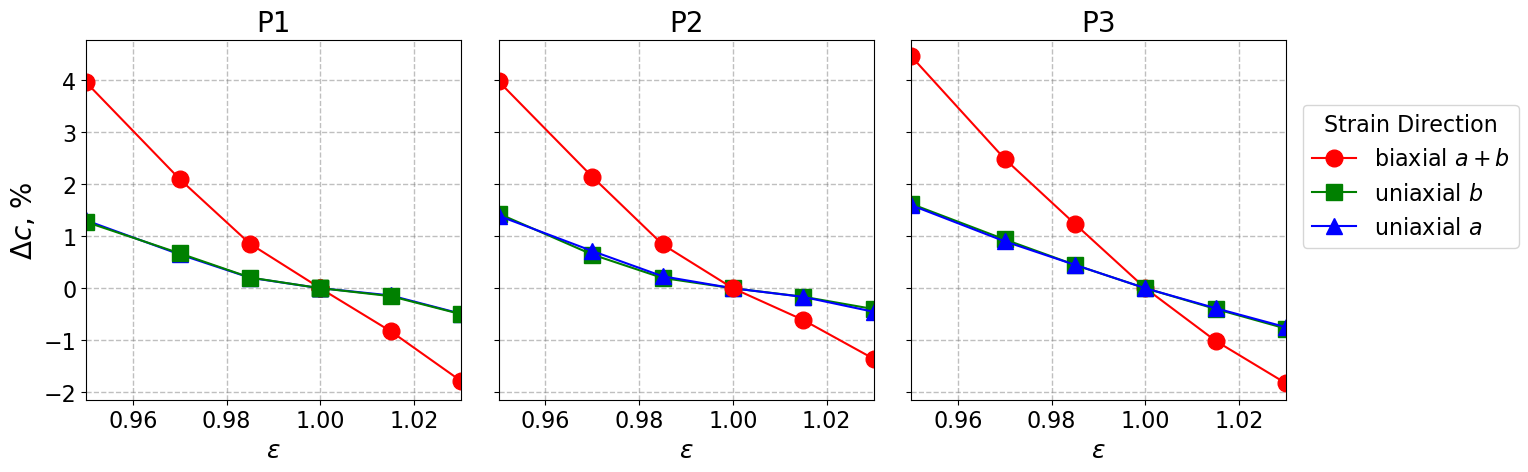

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_energies.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy

# Sort the data by the masks: biaxial, x-axis, y-axis
data = data.sort_values(by='mask')
# Get the unique dopants
dopants = data['dopant'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for dopant in dopants:
    # get the equilibrium data for the dopant
    equil_data = data[(data['dopant']==dopant) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])
# Sort the data by the in-plane strain
data = data.sort_values(by='in_plane')

# Set a color map for the masks
colors = ['r', 'g', 'b']
mask_colors = {mask:color for mask, color in zip(data['mask'].unique(), colors)}

markers = ['o', 's', '^'] 
mask_markers = {mask:marker for mask, marker in zip(data['mask'].unique(), markers)}

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Create a figure
fig, ax = plt.subplots(1, len(dopants), figsize=(20, 4), sharey=True, gridspec_kw={'top': 0.95, 'bottom': 0.05, 'left': 0.15, 'right': 0.75, 'wspace': 0.1})

xlims = [0.95, 1.03]

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $a+b$'}
handles = []
labels = []
for dopant in dopants:
    # Get the data for the dopant
    dopant_data = data[data['dopant']==dopant]
    # Get the unique mask values
    masks = dopant_data['mask'].unique()

    # Get the equilibrium energy
    for mask in masks:
        mask_data = dopant_data[dopant_data['mask']==mask]
        # Find the value of c_lat that corresponds to unstrained structure
        normalized_c = mask_data[mask_data['in_plane']==1.000]['c_lat'].values[0]
        ax[dopant-1].plot(mask_data['in_plane'], 100 *(mask_data['c_lat'] - normalized_c)/normalized_c, 
                          label=names_dict[mask], color=mask_colors[mask], marker=mask_markers[mask], markersize=12)
    ax[dopant-1].grid(True, linestyle='--', alpha=0.5, linewidth=1, color='gray')
    ax[dopant-1].set_xlim(xlims)
    ax[dopant-1].set_title(f'P{dopant}', fontsize=20)
    ax[dopant-1].set_xlabel(r'$\varepsilon$', fontsize=18)
    handles, labels = ax[dopant-1].get_legend_handles_labels()
    ax[dopant-1].yaxis.set_tick_params(labelsize=16)
    ax[dopant-1].xaxis.set_tick_params(labelsize=16)

ax[0].set_ylabel(r'$\Delta c$, %', fontsize=20)
plt.legend(handles, labels, loc='upper right', title='Strain Direction', bbox_to_anchor=(1.65, 0.85), ncol=1, fontsize=16, title_fontsize=16)
#plt.tight_layout()
plt.savefig('strained_perovskite_c_latt.svg', format='svg')
plt.show()


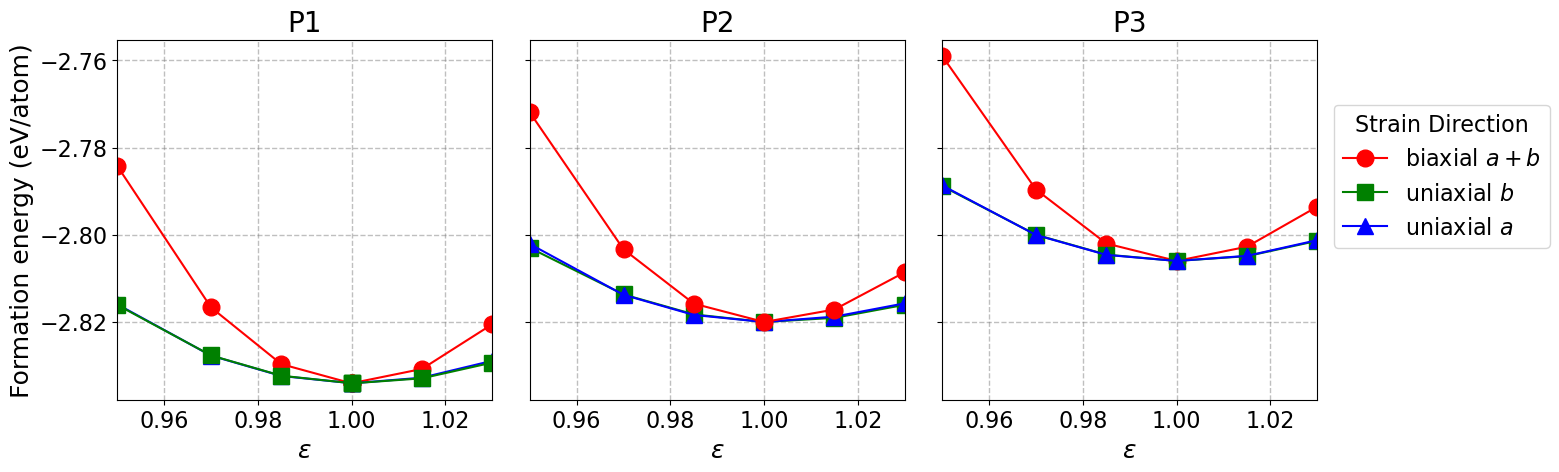

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_energies.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy

# Sort the data by the masks: biaxial, x-axis, y-axis
data = data.sort_values(by='mask')
# Get the unique dopants
dopants = data['dopant'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for dopant in dopants:
    # get the equilibrium data for the dopant
    equil_data = data[(data['dopant']==dopant) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])
# Sort the data by the in-plane strain
data = data.sort_values(by='in_plane')

# Set a color map for the masks
colors = ['r', 'g', 'b']
mask_colors = {mask:color for mask, color in zip(data['mask'].unique(), colors)}

markers = ['o', 's', '^'] 
mask_markers = {mask:marker for mask, marker in zip(data['mask'].unique(), markers)}

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Create a figure
fig, ax = plt.subplots(1, len(dopants), figsize=(20, 4), sharey=True, gridspec_kw={'top': 0.95, 'bottom': 0.05, 'left': 0.15, 'right': 0.75, 'wspace': 0.1})

xlims = [0.95, 1.03]

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $a+b$'}
handles = []
labels = []
for dopant in dopants:
    # Get the data for the dopant
    dopant_data = data[data['dopant']==dopant]
    # Get the unique mask values
    masks = dopant_data['mask'].unique()

    # Get the equilibrium energy
    for mask in masks:
        mask_data = dopant_data[dopant_data['mask']==mask]
        #min_energy = mask_data['energy'].min()
        #ax[dopant-1].plot(mask_data['in_plane'], 1000*(mask_data['energy'] - min_energy)/mask_data['natoms'], 
        ax[dopant-1].plot(mask_data['in_plane'], mask_data['hof'], 
                          label=names_dict[mask], color=mask_colors[mask], marker=mask_markers[mask], markersize=12)
    ax[dopant-1].grid(True, linestyle='--', alpha=0.5, linewidth=1, color='gray')
    ax[dopant-1].set_xlim(xlims)
    ax[dopant-1].set_title(f'P{dopant}', fontsize=20)
    ax[dopant-1].set_xlabel(r'$\varepsilon$', fontsize=18)
    handles, labels = ax[dopant-1].get_legend_handles_labels()
    ax[dopant-1].yaxis.set_tick_params(labelsize=16)
    ax[dopant-1].xaxis.set_tick_params(labelsize=16)

ax[0].set_ylabel('Formation energy (eV/atom)', fontsize=18)
plt.legend(handles, labels, loc='upper right', title='Strain Direction', bbox_to_anchor=(1.65, 0.85), ncol=1, fontsize=16, title_fontsize=16)
#plt.tight_layout()
plt.savefig('strained_perovskite_eof.svg')
plt.show()


### Now, the vacancies

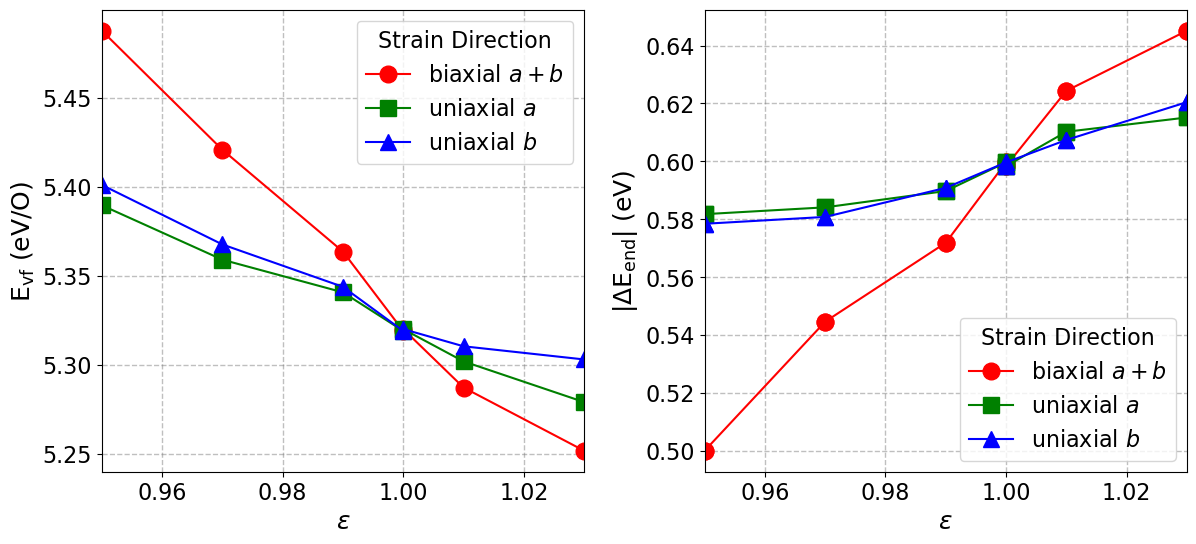

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_vacancies.csv')

# Sort the data by the masks: biaxial, x-axis, y-axis
data = data.sort_values(by='mask')

# Generate a copy of the 'equil' mask data for each of the masks in the data
equil_data = data[data['mask']=='equil']
for mask in data['mask'].unique():
    if mask != 'equil':
        mask_data = equil_data.copy()
        mask_data['mask'] = mask
        data = pd.concat([data, mask_data])

# Sort the data by the in-plane strain
data = data.sort_values(by='in_plane')

# Set a color map for the masks
colors = ['r', 'g', 'b']
mask_colors = {mask:color for mask, color in zip(data['mask'].unique(), colors)}

markers = ['o', 's', '^'] 
mask_markers = {mask:marker for mask, marker in zip(data['mask'].unique(), markers)}

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Create a two column figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'wspace':0.25})#{'top': 0.95, 'bottom': 0.05, 'left': 0.15, 'right': 0.9, })

xlims = [0.95, 1.03]

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $a+b$'}
handles = []
labels = []

property_labels = {'avg_oxy_vac_energy': r'$\mathrm{E_{vf}}$ (eV/O)', 'delta_e': r'|$\mathrm{\Delta E_{end}}$| (eV)'}
handles_ini = []
handles_fin = []
labels_ini = []
labels_fin = []

# Turn the delta_e values into absolute values
data['delta_e'] = np.abs(data['delta_e'])

# Create a new field averaging the oxy_vac_energy for the initial and final states 
for name, row in data.iterrows():
    vf_name = row['name'][:-2] + 'vf'
    vi_name = row['name'][:-2] + 'vi'
    vf_data = data[data['name']==vf_name]
    vi_data = data[data['name']==vi_name]
    data.loc[name, 'avg_oxy_vac_energy'] = 0.5 * (vf_data['oxy_vac_energy'].values[0] + vi_data['oxy_vac_energy'].values[0])

for i, property in enumerate(property_labels.keys()):
    masks = data['mask'].unique()
    for mask in masks:
        mask_data = data[data['mask']==mask]
        if property == 'avg_oxy_vac_energy':
            # Get only the initial states of the vacancies
            vi_data = mask_data[mask_data['name'].str.contains('_vi')]
            line, = ax[i].plot(vi_data['in_plane'], vi_data[property], 
                label=names_dict[mask], color=mask_colors[mask], marker=mask_markers[mask], markersize=12)
            ax[i].legend(loc='upper right', title='Strain Direction', ncol=1, fontsize=16, title_fontsize=16)
           
            #vi_data = mask_data[mask_data['name'].str.contains('_vi')]
            #vf_data = mask_data[mask_data['name'].str.contains('_vf')]
            #line_ini, = ax[i].plot(vi_data['in_plane'], vi_data[property], color=mask_colors[mask], marker=mask_markers[mask], markersize=12, label=f'{names_dict[mask]} ini')
            #line_fin, = ax[i].plot(vf_data['in_plane'], vf_data[property], color=mask_colors[mask], 
            #           markeredgecolor=mask_colors[mask], marker=mask_markers[mask], markerfacecolor='None', markeredgewidth=2, markersize=12, label=f'{names_dict[mask]} fin')
            
            #ax[i].fill_between(vi_data['in_plane'], vi_data[property].min(), vi_data[property].max(), color=mask_colors[mask], alpha=0.1)
            #ax[i].fill_between(vf_data['in_plane'], vf_data[property].min(), vf_data[property].max(), color=mask_colors[mask], alpha=0.1)
            
            #handles_ini.append(line_ini)
            #handles_fin.append(line_fin)
            #labels_ini.append(f'{names_dict[mask]} ini')
            #labels_fin.append(f'{names_dict[mask]} fin')
        else:
            line, = ax[i].plot(mask_data['in_plane'], mask_data[property], 
                label=names_dict[mask], color=mask_colors[mask], marker=mask_markers[mask], markersize=12)
            ax[i].legend(loc='lower right', title='Strain Direction', ncol=1, fontsize=16, title_fontsize=16)

    ax[i].grid(True, linestyle='--', alpha=0.5, linewidth=1, color='gray')
    ax[i].set_xlim(xlims)
    ax[i].set_title('')
    ax[i].set_xlabel(r'$\varepsilon$', fontsize=18)
    ax[i].yaxis.set_tick_params(labelsize=16)
    ax[i].xaxis.set_tick_params(labelsize=16)
    ax[i].set_ylabel(property_labels[property], fontsize=18)

# Create a custom legend
#ax[0].legend(handles_ini + handles_fin, labels_ini + labels_fin, 
#           loc='center', title='Strain Direction', 
#           #loc='center left', bbox_to_anchor=(1, 0.5), title='Strain Direction', 
#           ncol=2, fontsize=16, title_fontsize=16, handletextpad=0.5)
#           #columnspacing=1, handletextpad=0.5)

#plt.tight_layout()
#plt.subplots_adjust(right=0.85)  # Adjust the right margin to make space for the legend
plt.savefig('strained_perovskite_vacancies_v2.svg', format='svg')
plt.show()

### Now for the barriers of the NEBs

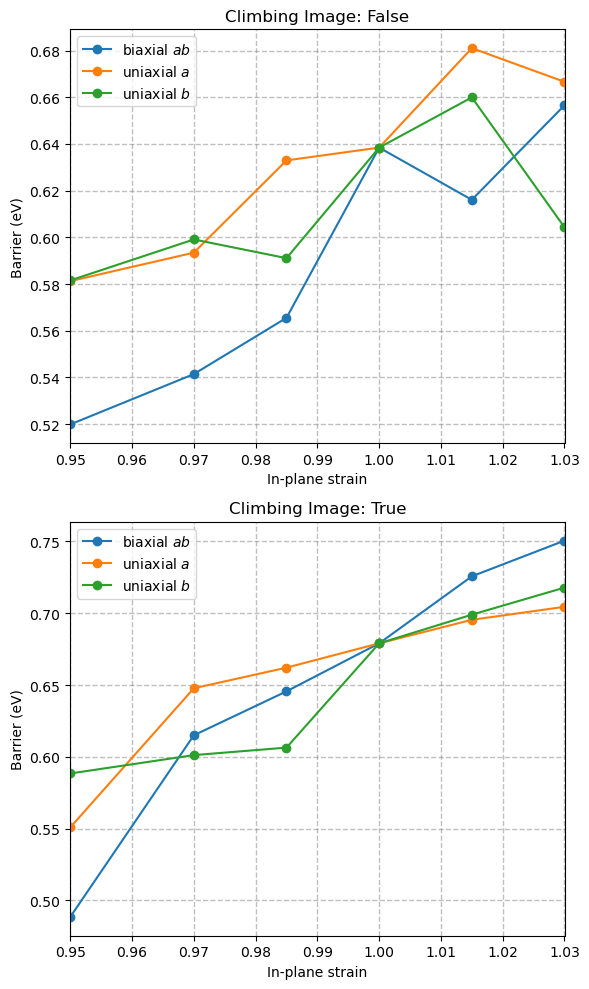

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_barriers.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy
barrier_types = data['climb'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for barrier_type in barrier_types:
    equil_data = data[(data['climb']==barrier_type) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])

# Sort the data by the in-plane strain
data = data.sort_values(by=['in_plane','mask', 'climb'])

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Create a figure
fig, ax = plt.subplots(len(barrier_types), 1, figsize=(6, 10))

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $ab$'}

xlims = [0.95, 1.03]

# There are two types of NEB calculations, those that are climbing image and those that are not. We will plot the barriers for each of these types
for i, barrier_type in enumerate(barrier_types):
    # Get the unique mask values
    barrier_type_data = data[data['climb']==barrier_type]
    masks = barrier_type_data['mask'].unique()
    # Get the equilibrium energy
    for mask in masks:
        mask_data = barrier_type_data[barrier_type_data['mask']==mask]
        ax[i].plot(mask_data['in_plane'], mask_data['kra'], label=names_dict[mask], marker='o')
    ax[i].grid(True, linestyle='--', alpha=0.5, linewidth=1, color='gray')
    ax[i].set_xlim(xlims)
    ax[i].set_title(f'Climbing Image: {barrier_type}')
    ax[i].set_xlabel('In-plane strain')
    ax[i].set_ylabel('Barrier (eV)')
    ax[i].legend()
plt.tight_layout()
plt.savefig('strained_barriers.png')
plt.show()



### NEB Landscapes

Generate the NEB energy landscape for the original run. 

Then add the variations of the strains, maybe only the first and last values and fill between?
Try for one then we see.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from forcecurve import fit_images
from ase.db import connect
from ase.io import read
%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_barriers.csv')

db_path = 'structures/hexag_perovs_strained.db'

with PersistentQueue() as pq:
    entries = pq.get_entries()

selection = Selection(states='s', names='CINEB*')
targets = selection.filter(entries)

cineb_ids = []
for entry in targets:
    cineb_ids.append(entry.data['neb_id'])

ci_neb_data = {}
with connect(db_path) as db:
    for id in cineb_ids:
        row = db.get(id=id)
        ci_neb_data[row.name] = row.dir

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy
barrier_types = data['climb'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for barrier_type in barrier_types:
    equil_data = data[(data['climb']==barrier_type) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])

# Sort the data by the in-plane strain
data = data.sort_values(by=['in_plane','mask', 'climb'])

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Drop the entries for which the climbing image is false
data = data[data['climb']==True]

# Keep the entries that match the cineb data dictionary
data = data[data['name'].isin(ci_neb_data.keys())]

# Get the rows that have the x-axis mask
#data = data[data['mask']=='x_axis']

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $ab$'}

energies_df = pd.DataFrame()

# Iterate over the rows, get the corresponding directory from the cineb data dictionary and plot the barriers
neb_images = {}
for index, row in data.iterrows():
    name = row['name']
    dir = Path(ci_neb_data[name])
    neb_images[name] = {
        '0' : dir / 'init' / 'vasprun.xml',
        '1' : dir / 'iimg01' / 'vasprun.xml',
        '2' : dir / 'iimg02' / 'vasprun.xml',
        '3' : dir / 'iimg03' / 'vasprun.xml',
        '4' : dir / 'final' / 'vasprun.xml',
    }
    images = []
    for key in neb_images[name].keys():
        images.append(read(neb_images[name][key], index=-1))

    _, _, _, interpolated_energies, _ = fit_images(images)

    min_energy = min(interpolated_energies) 
    
    fit_energies = np.array(interpolated_energies) - min_energy

    # Create a DataFrame from the fit_energies array
    fit_energies_df = pd.DataFrame(fit_energies).T

    # Add the name column to the fit_energies_df
    fit_energies_df.insert(0, 'name', name)

    # Concatenate the fit_energies_df to the energies_df
    energies_df = pd.concat([energies_df, fit_energies_df], ignore_index=True)

energies_df.to_csv('neb_energies_fit.csv', index=False)


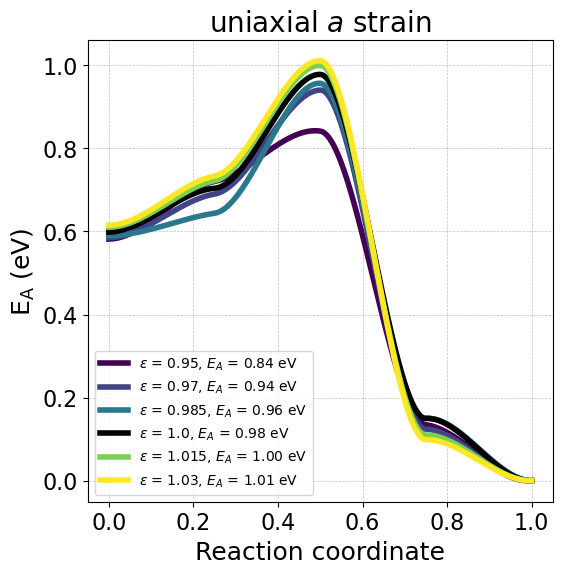

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_barriers.csv')
neb_energies = pd.read_csv('neb_energies_fit.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy
barrier_types = data['climb'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for barrier_type in barrier_types:
    equil_data = data[(data['climb']==barrier_type) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])

# Sort the data by the in-plane strain
data = data.sort_values(by=['in_plane','mask', 'climb'])

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Drop the entries for which the climbing image is false
data = data[data['climb']==True]

# Keep the entries that match the cineb data dictionary
data = data[data['name'].isin(ci_neb_data.keys())]

# Get the rows that have the x-axis mask
data = data[data['mask']=='x_axis']

cmap = plt.get_cmap('viridis')

colors_in_plane = np.linspace(0, 1, len(data['in_plane'].unique()))

colors = cmap(colors_in_plane)

in_plane_dict = {'s7': 1.070, 's5': 1.050, 's3': 1.030, 's1': 1.015, 'e0': 1.000, 'c1': 0.985, 'c3': 0.970, 'c5': 0.950, 'c7': 0.930}    


names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $ab$'}    
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for index, row in data.iterrows():
    name = row['name']
    fit_energies = neb_energies[neb_energies['name']==name].values[0][1:]
    in_plane = row['in_plane']
    mask = row['mask']
    label = fr'$\epsilon$ = {in_plane}, $E_A$ = {fit_energies.max():.2f} eV'
    

    # Normalize the path
    x = np.linspace(0, 1, len(fit_energies))
        
    if 'e0' not in name:
        ax.plot(x, fit_energies, label=label, color=colors[np.where(data['in_plane'].unique()==in_plane)[0][0]], linewidth=4)
    else:
        ax.plot(x, fit_energies, 'k-', linewidth=4, label=label)
    
    ax.set_xlabel('Reaction coordinate', fontsize=18)
    ax.set_ylabel(r'$\mathrm{E_A}$ (eV)', fontsize=18)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.legend()
    ax.set_title(f"{names_dict[mask]} strain", fontsize=20)
    ax.grid(True, linestyle='--', alpha=0.5, linewidth=0.5, color='gray')
    # 
    #plt.title(f"{name}, Barrier: {barrier:.2f} eV, Delta E: {delta_e:.2f} eV, KRA: {kra_energy:.2f} eV")
    #plt.savefig(f"{plot_dir}/{name}.png", bbox_inches='tight', dpi=300)
#    break
plt.show()

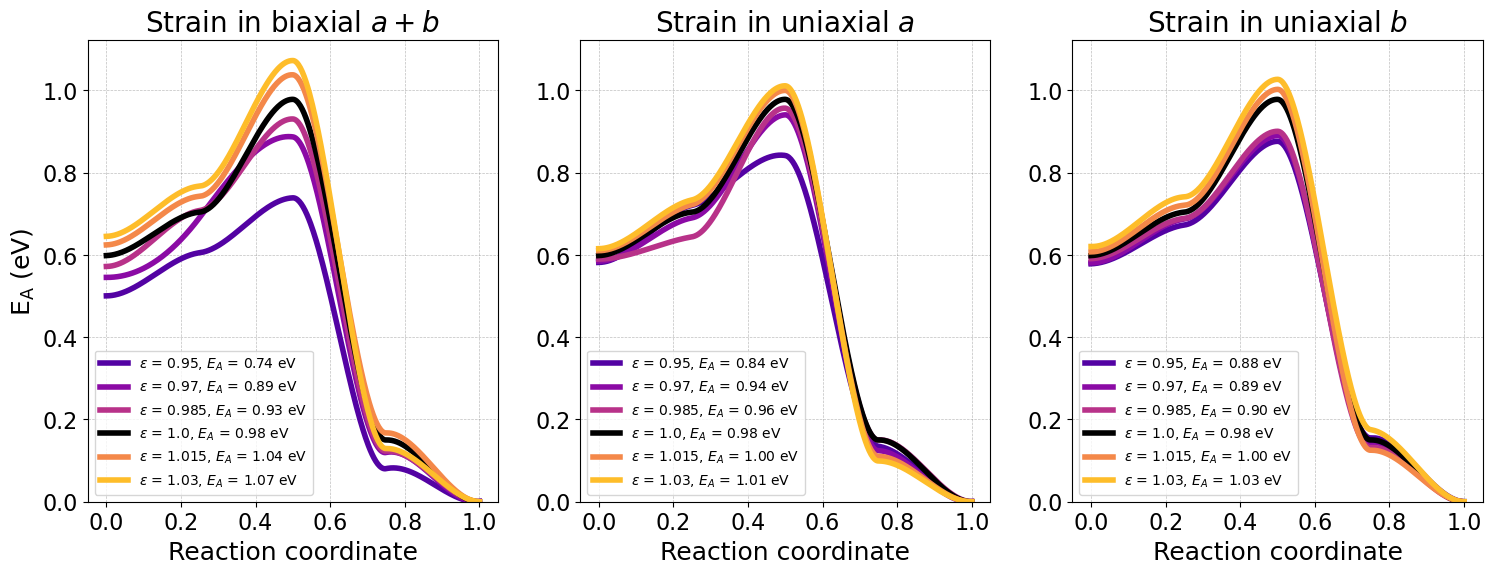

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ase.db import connect

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_barriers.csv')
neb_energies = pd.read_csv('neb_energies_fit.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy
barrier_types = data['climb'].unique()


# ci_neb_data = {}
# with connect(db_path) as db:
#     for id in cineb_ids:
#         row = db.get(id=id)
#         ci_neb_data[row.name] = row.dir

# Generate a copy of the 'equil' mask data for each of the masks in the data
for barrier_type in barrier_types:
    equil_data = data[(data['climb']==barrier_type) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])

# Sort the data by the in-plane strain
data = data.sort_values(by=['in_plane','mask', 'climb'])

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Drop the entries for which the climbing image is false
data = data[data['climb']==True]

# Keep the entries that match the cineb data dictionary
#data = data[data['name'].isin(ci_neb_data.keys())]

# Get the rows that have the x-axis mask
#data = data[data['mask']=='x_axis']

cmap = plt.get_cmap('plasma')

colors_in_plane = np.linspace(0, 1, len(data['in_plane'].unique())+2)

colors = cmap(colors_in_plane)
# Drop the last color
colors = colors[:-1]
# Drop the first color
colors = colors[1:]

in_plane_dict = {'s7': 1.070, 's5': 1.050, 's3': 1.030, 's1': 1.015, 'e0': 1.000, 'c1': 0.985, 'c3': 0.970, 'c5': 0.950, 'c7': 0.930}    

ylims = 0, data['barrier'].max()+.05
names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $a+b$'}    
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, mask in enumerate(data['mask'].unique()):
    mask_data = data[data['mask']==mask]
    for index, row in mask_data.iterrows():

        name = row['name']
        fit_energies = neb_energies[neb_energies['name']==name].values[0][1:]
        in_plane = row['in_plane']
        label = fr'$\epsilon$ = {in_plane}, $E_A$ = {fit_energies.max():.2f} eV'
        
#        print(index,name)
        # Normalize the path
        x = np.linspace(0, 1, len(fit_energies))
            
        if 'e0' not in name:
            ax[i].plot(x, fit_energies, label=label, color=colors[np.where(mask_data['in_plane'].unique()==in_plane)[0][0]], linewidth=4)
        
        # Plot the e0 line in black
        else:
            ax[i].plot(x, fit_energies, 'k-', linewidth=4, label=label, markersize=12)
        
        ax[i].set_xlabel('Reaction coordinate', fontsize=18)
        ax[i].yaxis.set_tick_params(labelsize=16)
        ax[i].xaxis.set_tick_params(labelsize=16)
        ax[i].set_ylim(ylims)
        ax[i].legend()
        ax[i].set_title(f"Strain in {names_dict[mask]}", fontsize=20)
        ax[i].grid(True, linestyle='--', alpha=0.5, linewidth=0.5, color='gray')
    
ax[0].set_ylabel(r'$\mathrm{E_A}$ (eV)', fontsize=18)
plt.savefig("neb_energies_fit.svg", bbox_inches='tight')
plt.show()

### Additional analysis

Calculate the critical radius of the structures.

In [38]:
import pandas as pd
import numpy as np
from pathlib import Path
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from ase.io import read
from typing import List
from itertools import product
from functools import lru_cache
from json import load
from ase import data
from ase.neighborlist import NeighborList
import pandas as pd
from ase.atoms import Atoms
import matplotlib.pyplot as plt

def get_ox(states: list, amount: int) -> list:
    states = [s for s in states if s > 0]
    return np.unique([p for p in product(states, repeat=amount)])

def get_B_ox_states(states: list, amount: int) -> List[list]:
    states = [s for s in states if s > 0]
    return np.unique(
        np.sort(
            list(product(states, repeat=amount)), axis=1
        ), axis=0
    )

# Get the oxidation states.
def electroneutral_ox_states(A_atom: str, B_atom: str, Bp_atom: str
                         ):
    data = load_data()
    ox_states = {e: [int(i) for i in data[e]['Shannon radii'].keys()]
                 for e in [A_atom, B_atom, Bp_atom]}

    ox_A = get_ox(ox_states[A_atom], 7)[-1]
    ox_Bs = get_B_ox_states(ox_states[B_atom], 4)
    ox_Bp = get_ox(ox_states[Bp_atom], 1)
    B_site_ox_states = [
        [*b, bp] for b in ox_Bs for bp in ox_Bp
    ]
    combs = [(sum(p) + ox_A*7 - 2*20, p) for p in B_site_ox_states
             if 0 == sum(p) + ox_A*7 - 2*20]
    
    if not combs:
        return None
    if len(combs) == 1:
        c = combs[0][1]
        return {A_atom: ox_A, B_atom: c[:-1], Bp_atom: c[-1]}

    X_B = data[B_atom]['X']
    X_Bp = data[Bp_atom]['X']
    states = reversed([p for _, p in combs])

    if X_B/X_Bp <= 0.9:
        c = max(states, key=lambda p: p[-1] - np.mean(p[:-1]))
    elif X_B/X_Bp < 1.1:
        c = min(states, key=lambda p: abs(np.mean(p[:-1]) - p[-1]))
    else:
        c = max(states, key=lambda p: np.mean(p[:-1]) - p[-1])
    
    return {A_atom: ox_A, B_atom: c[:-1], Bp_atom: c[-1]}

# Get the ionic radii
def Shannon_radius(atom: str, oxidation_state: int, coordination: str = "VI"):
    data = load_data()
    dct = data[atom]['Shannon radii'][str(oxidation_state)]
    # Get the required coordination, or just any
    dct = dct.get(coordination, dct[list(dct.keys())[0]])
    return dct.get('', dct.get('High Spin'))['ionic_radius']

# Load JSON data from file
@lru_cache
def load_data() -> dict:
    with open('data/periodic_table.json') as fd:
        return load(fd)

def get_nearest_neighbors(cutoffs, index, atoms):
    if cutoffs is None:
        cutoffs = [1.25 * data.covalent_radii[atom.number] for atom in atoms]
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)
    return nl.get_neighbors(index)[0]
    
def get_nearest_indices(cutoffs, index, atoms):
    neighbors = get_nearest_neighbors(cutoffs, index, atoms)
    return [atoms[s].index for s in neighbors]

def get_nearest_distances(cutoffs, index, atoms):
    # Get the cartesian coordinates of the neighbors and the dopant atom and extract the distances
    neighbors = get_nearest_neighbors(cutoffs, index, atoms)
    distances = []
    for n in neighbors:
        distances.append(atoms.get_distance(index, n, mic=True))
    return distances

def get_critical_radius(atoms: Atoms, moving_o: int):
    
    a_site = 'Ba'
    b_site = 'Nb'
    bp_site = 'Mo'
    
    # Create an oxidation states dictionary
    ox_states = electroneutral_ox_states(a_site, b_site, bp_site)
    # Loop over the oxidation states dictionary and make sure the oxidation states are integers
    for k,v in ox_states.items():
        if isinstance(v, list):
            ox_states[k] = set(v).pop()

    #print(ox_states)
    moving_o = 126
    
    # Since this is a 3D problem, focusing only on two radii is not the best way to go. 
    # Therefore, I will obtain the neighbors of the moving oxygen atom and obtain the largest possible sphere that can be inscribed in the tetrahedron formed by the neighbors of the moving oxygen atom.
    nl = get_nearest_neighbors(None, moving_o, atoms)
    #print(nl)

    # Get the ionic radii of the atoms in the nl
    ionic_radii = {}
    for n in nl:
        atom = atoms[n]
        ionic_radii[n] = Shannon_radius(atom.symbol, ox_states[atom.symbol], "VI")


    # Get the distances between the moving oxygen atom and its neighbors after removing the ionic radii
    distances = get_nearest_distances(None, moving_o, atoms)
    distances = [d - ionic_radii[n] for n, d in zip(nl, distances)]
    neighbor_distances = [(n, d) for n, d in zip(nl, distances)]
    neighbor_distances = sorted(neighbor_distances, key=lambda x: x[1])
    #print(neighbor_distances)

    # We can define the critical radius as the minimum distance between the moving oxygen atom and its neighbors, since this is the largest sphere that can be inscribed in the tetrahedron formed by the neighbors of the moving oxygen atom.
    critical_radius = neighbor_distances[0][1]

    # Print the critical radius
    return critical_radius

# Read the data from the csv file
df = pd.read_csv('strained_perovskite_barriers.csv')

db_path = 'structures/hexag_perovs_strained.db'

with PersistentQueue() as pq:
    entries = pq.get_entries()

selection = Selection(states='s', names='CINEB*')
targets = selection.filter(entries)

cineb_ids = []
for entry in targets:
    cineb_ids.append(entry.data['neb_id'])

ci_neb_data = {}
with connect(db_path) as db:
    for id in cineb_ids:
        row = db.get(id=id)
        ci_neb_data[row.name] = row.dir

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy
barrier_types = df['climb'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the df
for barrier_type in barrier_types:
    equil_data = df[(df['climb']==barrier_type) & (df['mask']=='equil')]
    for mask in df['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            df = pd.concat([df, mask_data])

# Sort the df by the in-plane strain
df = df.sort_values(by=['in_plane','mask', 'climb'])

# Drop the 'equil' mask df
df = df[df['mask']!='equil']

# Drop the entries for which the climbing image is false
df = df[df['climb']==True]

# Keep the entries that match the cineb df dictionary
df = df[df['name'].isin(ci_neb_data.keys())]

# Get the rows that have the x-axis mask
#df = df[df['mask']=='x_axis']

names_dict = {'x_axis': r'uniaxial $a$', 'y_axis': r'uniaxial $b$', 'biaxial': r'biaxial $ab$'}

# Iterate over the rows, get the corresponding directory from the cineb df dictionary and plot the barriers
neb_images = {}
for index, row in df.iterrows():
    name = row['name']
    neb_id = db.get(name=name).id
    atoms = db.get(id=neb_id).toatoms()
    crit_rad = get_critical_radius(atoms = atoms, moving_o = 126)
    barrier = row['barrier'] 
    kra_energy = row['kra']
 
    #dir = Path(ci_neb_data[name])
    #ts_atoms = read(dir / 'iimg02' / 'vasprun.xml', index=-1)
    print(f'{name}: {crit_rad:.2f} A, {barrier:.2f} eV, {kra_energy:.2f} eV')

    # Store the critical radius in the df
    df.loc[index, 'critical_radius'] = crit_rad

# Save the df to a csv file
df.to_csv('strained_perovskite_barriers.csv', index=False)


Ba7Nb4MoO20_p1_biaxial_c5_CI_neb: 1.26 A, 0.74 eV, 0.49 eV
Ba7Nb4MoO20_p1_x_axis_c5_CI_neb: 1.32 A, 0.84 eV, 0.55 eV
Ba7Nb4MoO20_p1_y_axis_c5_CI_neb: 1.28 A, 0.88 eV, 0.59 eV
Ba7Nb4MoO20_p1_biaxial_c3_CI_neb: 1.29 A, 0.89 eV, 0.61 eV
Ba7Nb4MoO20_p1_x_axis_c3_CI_neb: 1.28 A, 0.94 eV, 0.65 eV
Ba7Nb4MoO20_p1_y_axis_c3_CI_neb: 1.28 A, 0.89 eV, 0.60 eV
Ba7Nb4MoO20_p1_x_axis_c1_CI_neb: 1.29 A, 0.96 eV, 0.66 eV
Ba7Nb4MoO20_p1_biaxial_e0_CI_neb: 1.29 A, 0.98 eV, 0.68 eV
Ba7Nb4MoO20_p1_biaxial_e0_CI_neb: 1.29 A, 0.98 eV, 0.68 eV
Ba7Nb4MoO20_p1_biaxial_e0_CI_neb: 1.29 A, 0.98 eV, 0.68 eV
Ba7Nb4MoO20_p1_biaxial_s1_CI_neb: 1.29 A, 1.04 eV, 0.73 eV
Ba7Nb4MoO20_p1_x_axis_s1_CI_neb: 1.29 A, 1.00 eV, 0.70 eV
Ba7Nb4MoO20_p1_biaxial_s3_CI_neb: 1.28 A, 1.07 eV, 0.75 eV
Ba7Nb4MoO20_p1_x_axis_s3_CI_neb: 1.28 A, 1.01 eV, 0.70 eV
Ba7Nb4MoO20_p1_y_axis_s3_CI_neb: 1.28 A, 1.03 eV, 0.72 eV


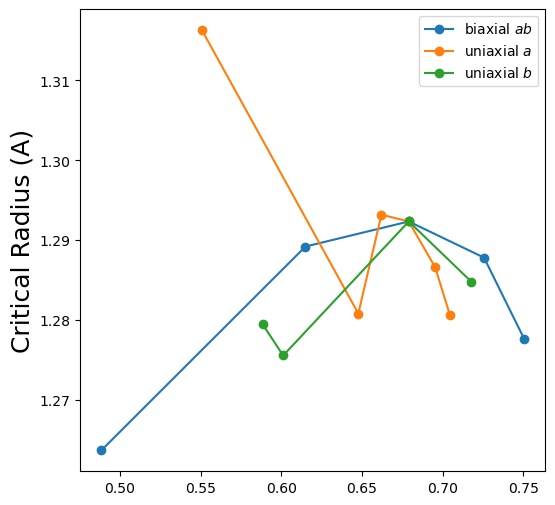

In [42]:
%matplotlib inline
# Plot critical radius vs barrier for all directions of strain
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for mask in df['mask'].unique():
    mask_data = df[df['mask']==mask]
    ax.plot(mask_data['kra'], mask_data['critical_radius'],  'o-', label=names_dict[mask])
ax.set_ylabel('Critical Radius (A)', fontsize=18)
#ax.set_ylabel('Barrier (eV)', fontsize=18)
ax.legend()
plt.show()